# Grocery Inventory Analysis

This notebook contains a complete analysis of grocery inventory and sales data, with all functions defined directly within the notebook (no imports from external Python files).

## 1. Setup and Imports

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta

# Set up directories
OUTPUT_DIR = 'outputs'
PLOTS_DIR = os.path.join(OUTPUT_DIR, 'plots')
REPORTS_DIR = os.path.join(OUTPUT_DIR, 'reports')

# Ensure directories exist
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

## 2. Function Definitions

In [7]:
# Data loading function
def load_data(file_path):
    print(f"Loading data from {file_path}")
    return pd.read_csv(file_path)

In [8]:
# Data validation function
def validate_data(df):
    print("Validating data...")
    
    # Check required columns
    required_columns = [
        'Product_ID', 'Catagory', 'Stock_Quantity', 'Reorder_Level',
        'Unit_Price', 'Sales_Volume', 'Expiration_Date'
    ]
    
    # Map dataset columns to required columns for analysis
    column_mapping = {
        'Catagory': 'Product_Category',
        'Sales_Volume': 'Quantity_Sold',
        'Stock_Quantity': 'Stock_On_Hand',
        'Expiration_Date': 'Expiry_Date'
    }
    
    # Rename columns for analysis
    df = df.rename(columns=column_mapping)
    
    # Convert price columns from string to float (remove $ and convert)
    if 'Unit_Price' in df.columns:
        df['Unit_Price'] = df['Unit_Price'].str.replace('$', '').str.strip().astype(float)
    
    # Convert dates to datetime
    if 'Expiry_Date' in df.columns:
        df['Expiry_Date'] = pd.to_datetime(df['Expiry_Date'], errors='coerce')
    
    # Calculate profit based on sales and price if not available
    if 'Profit' not in df.columns:
        # Assuming 20% profit margin for simplicity
        df['Profit'] = df['Quantity_Sold'] * df['Unit_Price'] * 0.2
    
    # Add a Discount column if not present (set to 0)
    if 'Discount_%' not in df.columns:
        df['Discount_%'] = 0
    
    return df

In [9]:
# Data preprocessing function
def preprocess_data(df):
    print("Preprocessing data...")
    
    # Handle missing values
    for col in df.columns:
        if df[col].dtype in [np.int64, np.float64]:
            # Fill numeric columns with median
            df[col] = df[col].fillna(df[col].median())
        else:
            # Fill categorical columns with "Unknown" or most frequent
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")
    
    # Outlier treatment for numeric columns
    for col in ['Quantity_Sold', 'Stock_On_Hand']:
        if col in df.columns:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            upper_bound = q3 + 1.5 * iqr
            # Cap values above 95th percentile
            df[col] = np.where(df[col] > df[col].quantile(0.95), df[col].quantile(0.95), df[col])
    
    # Create derived columns
    df['Inventory_Turnover_Ratio'] = df['Quantity_Sold'] / df['Stock_On_Hand']
    df['Overstock_Flag'] = df['Stock_On_Hand'] > 2 * df['Reorder_Level']
    
    # If Reorder_Level is missing, assume it as Avg_Monthly_Sales * 1.5
    # (using Quantity_Sold as a proxy for monthly sales)
    if 'Reorder_Level' in df.columns and df['Reorder_Level'].isna().any():
        df['Reorder_Level'] = df['Reorder_Level'].fillna(df['Quantity_Sold'] * 1.5)
    
    # Calculate total revenue
    df['Total_Revenue'] = df['Quantity_Sold'] * df['Unit_Price']
    
    return df

In [1]:
# Analysis: Overstocked Products
def analyze_overstocked_products(df):
    print("[PRIORITY] Analyzing overstocked products...")
    
    # Filter overstocked products
    overstocked = df[df['Overstock_Flag'] == True].sort_values(by='Stock_On_Hand', ascending=False)
    
    # Create report
    overstocked_report = overstocked[['Product_ID', 'Product_Name', 'Product_Category', 
                                     'Stock_On_Hand', 'Reorder_Level', 'Quantity_Sold', 
                                     'Inventory_Turnover_Ratio']]
    
    # Save report
    overstocked_report.to_csv(os.path.join(REPORTS_DIR, 'overstocked_products.csv'), index=False)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(data=overstocked.head(15), x='Product_Name', y='Stock_On_Hand')
    plt.xticks(rotation=90)
    plt.title('Top 15 Overstocked Products')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'overstocked_products.png'))
    
    return overstocked

In [11]:
# Analysis: Top Products
def analyze_top_products(df):
    print("[PRIORITY] Analyzing top products by quantity sold and revenue...")
    
    # Top products by quantity sold
    top_by_quantity = df.sort_values(by='Quantity_Sold', ascending=False).head(10)
    
    # Top products by revenue
    top_by_revenue = df.sort_values(by='Total_Revenue', ascending=False).head(10)
    
    # Save reports
    top_by_quantity[['Product_ID', 'Product_Name', 'Product_Category', 'Quantity_Sold', 
                    'Unit_Price', 'Total_Revenue']].to_csv(
                    os.path.join(REPORTS_DIR, 'top_products_by_quantity.csv'), index=False)
    
    top_by_revenue[['Product_ID', 'Product_Name', 'Product_Category', 'Quantity_Sold', 
                   'Unit_Price', 'Total_Revenue']].to_csv(
                   os.path.join(REPORTS_DIR, 'top_products_by_revenue.csv'), index=False)
    
    # Create visualizations
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_by_quantity, x='Product_Name', y='Quantity_Sold')
    plt.xticks(rotation=90)
    plt.title('Top 10 Products by Quantity Sold')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'top_products_by_quantity.png'))
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_by_revenue, x='Product_Name', y='Total_Revenue')
    plt.xticks(rotation=90)
    plt.title('Top 10 Products by Revenue')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'top_products_by_revenue.png'))
    
    return top_by_quantity, top_by_revenue

In [12]:
# Analysis: Category Revenue
def analyze_category_revenue(df):
    print("[PRIORITY] Analyzing category-wise revenue...")
    
    # Aggregate by category
    category_revenue = df.groupby('Product_Category').agg({
        'Total_Revenue': 'sum',
        'Quantity_Sold': 'sum',
        'Product_ID': 'count'  # count of products
    }).reset_index().sort_values(by='Total_Revenue', ascending=False)
    
    category_revenue = category_revenue.rename(columns={'Product_ID': 'Product_Count'})
    
    # Save report
    category_revenue.to_csv(os.path.join(REPORTS_DIR, 'category_revenue.csv'), index=False)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(data=category_revenue, x='Product_Category', y='Total_Revenue')
    plt.xticks(rotation=45)
    plt.title('Total Revenue by Product Category')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'category_revenue.png'))
    
    return category_revenue

In [13]:
# Analysis: Expiry Risk
def analyze_expiry_risk(df):
    print("[PRIORITY] Analyzing expiry risk...")
    
    if 'Expiry_Date' not in df.columns:
        print("Expiry_Date column not available. Skipping expiry risk analysis.")
        return None
    
    # Calculate days until expiry
    today = datetime.now()
    df['Days_To_Expiry'] = (df['Expiry_Date'] - today).dt.days
    
    # Create risk categories
    df['Expiry_Risk'] = 'Green'
    df.loc[df['Days_To_Expiry'] <= 60, 'Expiry_Risk'] = 'Yellow'
    df.loc[df['Days_To_Expiry'] <= 30, 'Expiry_Risk'] = 'Red'
    
    # Filter products with expiry risk
    at_risk = df[df['Expiry_Risk'] != 'Green'].sort_values(by='Days_To_Expiry')
    
    # Focus on products with stock
    at_risk_with_stock = at_risk[at_risk['Stock_On_Hand'] > 0]
    
    # Save report
    at_risk_with_stock[['Product_ID', 'Product_Name', 'Product_Category', 
                       'Stock_On_Hand', 'Days_To_Expiry', 'Expiry_Risk', 'Unit_Price']].to_csv(
                       os.path.join(REPORTS_DIR, 'expiry_risk.csv'), index=False)
    
    # Create visualization - count of products by risk category
    risk_counts = at_risk_with_stock['Expiry_Risk'].value_counts().reset_index()
    risk_counts.columns = ['Risk_Category', 'Count']
    
    plt.figure(figsize=(10, 6))
    colors = {'Red': 'red', 'Yellow': 'yellow', 'Green': 'green'}
    ax = sns.barplot(data=risk_counts, x='Risk_Category', y='Count', palette=colors)
    plt.title('Product Count by Expiry Risk Category')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'expiry_risk.png'))
    
    return at_risk_with_stock

In [14]:
# Analysis: Discount Impact
def analyze_discount_impact(df):
    print("[OPTIONAL] Analyzing discount impact...")
    
    if 'Discount_%' not in df.columns or df['Discount_%'].sum() == 0:
        print("Discount data not available or all values are 0. Skipping discount impact analysis.")
        return None
    
    # Create scatter plot of Discount vs Quantity Sold
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Discount_%', y='Quantity_Sold')
    plt.title('Impact of Discount on Quantity Sold')
    plt.xlabel('Discount %')
    plt.ylabel('Quantity Sold')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'discount_impact.png'))
    
    # Correlation analysis
    correlation = df['Discount_%'].corr(df['Quantity_Sold'])
    
    with open(os.path.join(REPORTS_DIR, 'discount_correlation.txt'), 'w') as f:
        f.write(f"Correlation between Discount and Quantity Sold: {correlation:.4f}")
    
    return correlation

In [15]:
# Generate Executive Summary
def generate_executive_summary(df, overstocked, top_revenue, category_revenue, expiry_risk):
    print("Generating executive summary...")
    
    insights = []
    
    # Insight 1: Overstocked products
    if overstocked is not None and not overstocked.empty:
        overstock_value = (overstocked['Stock_On_Hand'] * overstocked['Unit_Price']).sum()
        insights.append(f"[PRIORITY] There are {len(overstocked)} overstocked products with a total value of ${overstock_value:.2f}. Consider running promotions or reducing reorder quantities.")
    
    # Insight 2: Top revenue generators
    if top_revenue is not None and not top_revenue.empty:
        top_category = category_revenue.iloc[0]['Product_Category']
        top_revenue_pct = (category_revenue.iloc[0]['Total_Revenue'] / category_revenue['Total_Revenue'].sum()) * 100
        insights.append(f"[PRIORITY] The {top_category} category generates ${category_revenue.iloc[0]['Total_Revenue']:.2f} in revenue ({top_revenue_pct:.1f}% of total). Consider expanding this product line.")
    
    # Insight 3: Expiry risk
    if expiry_risk is not None and not expiry_risk.empty:
        red_risk = expiry_risk[expiry_risk['Expiry_Risk'] == 'Red']
        if not red_risk.empty:
            red_risk_value = (red_risk['Stock_On_Hand'] * red_risk['Unit_Price']).sum()
            insights.append(f"[PRIORITY] {len(red_risk)} products worth ${red_risk_value:.2f} will expire within 30 days. Immediate action required with promotions or discounts.")
    
    # Insight 4: Inventory turnover
    low_turnover = df[df['Inventory_Turnover_Ratio'] < 1].sort_values(by='Inventory_Turnover_Ratio')
    if not low_turnover.empty:
        low_turnover_value = (low_turnover['Stock_On_Hand'] * low_turnover['Unit_Price']).sum()
        insights.append(f"[PRIORITY] {len(low_turnover)} products have low turnover rates (<1), tying up ${low_turnover_value:.2f} in inventory. Review pricing strategy and promotions.")
    
    # Insight 5: Stock-outs risk
    potential_stockouts = df[df['Stock_On_Hand'] < df['Reorder_Level']]
    if not potential_stockouts.empty:
        high_revenue_at_risk = potential_stockouts.sort_values(by='Total_Revenue', ascending=False).head(5)
        at_risk_revenue = high_revenue_at_risk['Total_Revenue'].sum()
        insights.append(f"[PRIORITY] {len(potential_stockouts)} products are below reorder levels, putting ${at_risk_revenue:.2f} in revenue at risk. Expedite restocking of top sellers.")
    
    # Write to file
    with open(os.path.join(REPORTS_DIR, 'executive_summary.md'), 'w') as f:
        f.write("# Executive Summary: Grocery Inventory and Sales Analysis\n\n")
        f.write("## Key Insights and Action Items\n\n")
        for i, insight in enumerate(insights[:5], 1):
            f.write(f"{i}. {insight}\n\n")
    
    return insights

## 3. Data Loading and Processing

In [16]:
# Load data
data_path = 'data/Grocery_Inventory_and_Sales_Dataset.csv'
df = load_data(data_path)

# Display first few rows of the raw data
print("Raw data preview:")
df.head()

Loading data from data/Grocery_Inventory_and_Sales_Dataset.csv
Raw data preview:


,Product_ID,Product_Name,Catagory,Supplier_ID,Supplier_Name,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Date_Received,Last_Order_Date,Expiration_Date,Warehouse_Location,Sales_Volume,Inventory_Turnover_Rate,Status
0,29-205-1132,Sushi Rice,Grains & Pulses,38-037-1699,Jaxnation,22,72,70,$4.50,8/16/2024,6/29/2024,9/19/2024,48 Del Sol Trail,32,19,Discontinued
1,40-681-9981,Arabica Coffee,Beverages,54-470-2479,Feedmix,45,77,2,$20.00,11/1/2024,5/29/2024,5/8/2024,36 3rd Place,85,1,Discontinued
2,06-955-3428,Black Rice,Grains & Pulses,54-031-2945,Vinder,30,38,83,$6.00,8/3/2024,6/10/2024,9/22/2024,3296 Walton Court,31,34,Backordered
3,71-594-6552,Long Grain Rice,Grains & Pulses,63-492-7603,Brightbean,12,59,62,$1.50,12/8/2024,2/19/2025,4/17/2024,3 Westerfield Crossing,95,99,Active
4,57-437-1828,Plum,Fruits & Vegetables,54-226-4308,Topicstorm,37,30,74,$4.00,7/3/2024,10/11/2024,10/5/2024,15068 Scoville Court,62,25,Backordered


In [17]:
# Data info and missing values
print("Data info:")
df.info()

print("\nMissing values:")
df.isnull().sum()

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Product_ID               990 non-null    object
 1   Product_Name             990 non-null    object
 2   Catagory                 989 non-null    object
 3   Supplier_ID              990 non-null    object
 4   Supplier_Name            990 non-null    object
 5   Stock_Quantity           990 non-null    int64 
 6   Reorder_Level            990 non-null    int64 
 7   Reorder_Quantity         990 non-null    int64 
 8   Unit_Price               990 non-null    object
 9   Date_Received            990 non-null    object
 10  Last_Order_Date          990 non-null    object
 11  Expiration_Date          990 non-null    object
 12  Warehouse_Location       990 non-null    object
 13  Sales_Volume             990 non-null    int64 
 14  Inventory_Turnover_Rate  990 no

Product_ID                 0
Product_Name               0
Catagory                   1
Supplier_ID                0
Supplier_Name              0
Stock_Quantity             0
Reorder_Level              0
Reorder_Quantity           0
Unit_Price                 0
Date_Received              0
Last_Order_Date            0
Expiration_Date            0
Warehouse_Location         0
Sales_Volume               0
Inventory_Turnover_Rate    0
Status                     0
dtype: int64

In [18]:
# Validate and preprocess data
df_validated = validate_data(df)
df_processed = preprocess_data(df_validated)

# Display first few rows of the processed data
print("Processed data preview:")
df_processed.head()

Validating data...
Preprocessing data...
Processed data preview:


,Product_ID,Product_Name,Product_Category,Supplier_ID,Supplier_Name,Stock_On_Hand,Reorder_Level,Reorder_Quantity,Unit_Price,Date_Received,...,Expiry_Date,Warehouse_Location,Quantity_Sold,Inventory_Turnover_Rate,Status,Profit,Discount_%,Inventory_Turnover_Ratio,Overstock_Flag,Total_Revenue
0,29-205-1132,Sushi Rice,Grains & Pulses,38-037-1699,Jaxnation,22.0,72,70,4.5,8/16/2024,...,2024-09-19,48 Del Sol Trail,32.0,19,Discontinued,28.8,0,1.454545,False,144.0
1,40-681-9981,Arabica Coffee,Beverages,54-470-2479,Feedmix,45.0,77,2,20.0,11/1/2024,...,2024-05-08,36 3rd Place,85.0,1,Discontinued,340.0,0,1.888889,False,1700.0
2,06-955-3428,Black Rice,Grains & Pulses,54-031-2945,Vinder,30.0,38,83,6.0,8/3/2024,...,2024-09-22,3296 Walton Court,31.0,34,Backordered,37.2,0,1.033333,False,186.0
3,71-594-6552,Long Grain Rice,Grains & Pulses,63-492-7603,Brightbean,12.0,59,62,1.5,12/8/2024,...,2024-04-17,3 Westerfield Crossing,95.0,99,Active,28.5,0,7.916667,False,142.5
4,57-437-1828,Plum,Fruits & Vegetables,54-226-4308,Topicstorm,37.0,30,74,4.0,7/3/2024,...,2024-10-05,15068 Scoville Court,62.0,25,Backordered,49.6,0,1.675676,False,248.0


## 4. Analysis: Overstocked Products

[PRIORITY] Analyzing overstocked products...
Found 258 overstocked products


,Product_ID,Product_Name,Product_Category,Stock_On_Hand,Reorder_Level,Inventory_Turnover_Ratio
909,67-382-4435,Green Beans,Fruits & Vegetables,96.55,37,0.476437
159,49-861-7823,Coconut,Fruits & Vegetables,96.55,8,0.424650
140,02-655-3240,Rice Flour,Grains & Pulses,96.55,44,0.372864
899,77-827-0820,Sesame Oil,Oils & Fats,96.55,20,0.528224
902,44-128-2185,Jasmine Rice,Grains & Pulses,96.55,20,0.528224
747,54-758-4622,Chocolate Biscuit,Bakery,96.55,3,0.673226
718,08-637-9335,Lettuce,Fruits & Vegetables,96.55,7,0.269291
225,56-191-6497,Bread Flour,Grains & Pulses,96.55,41,0.362506
245,59-075-2457,Egg (Goose),Dairy,96.55,26,0.341792
855,46-911-1159,Onion,Fruits & Vegetables,96.55,40,0.476437


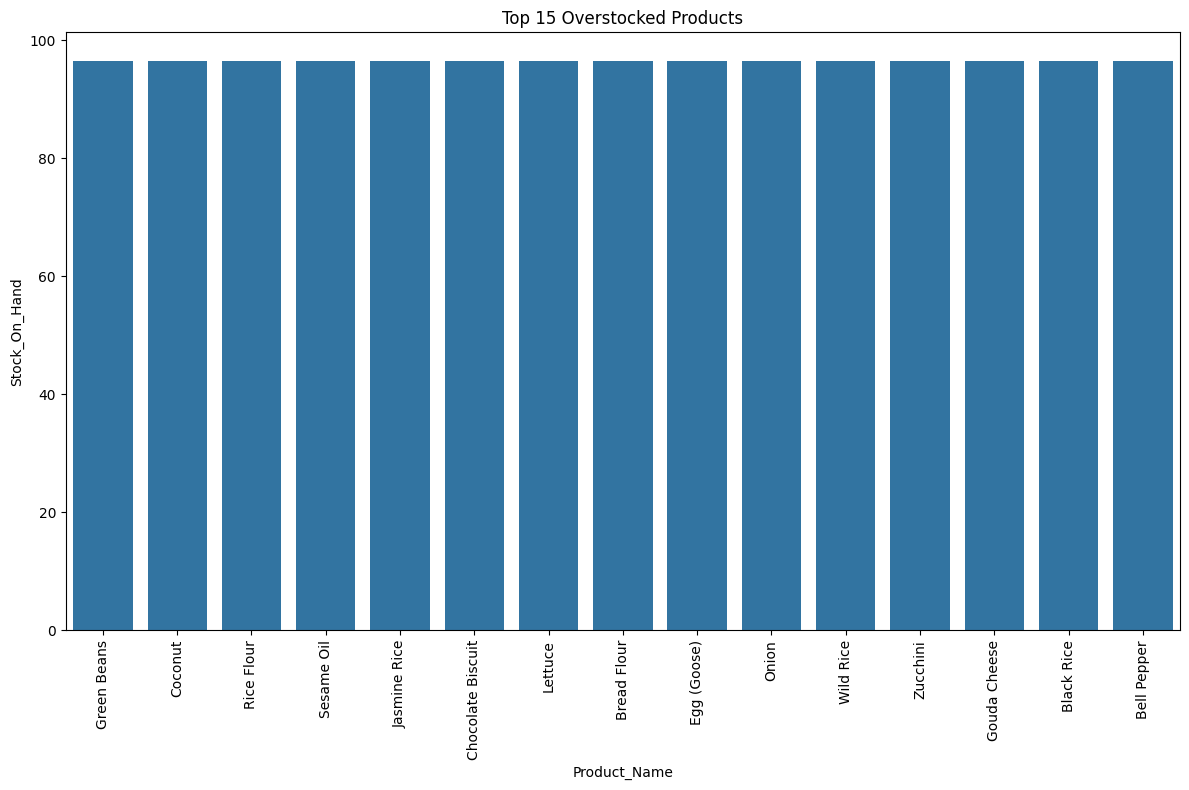

In [19]:
# Analyze overstocked products
overstocked = analyze_overstocked_products(df_processed)

# Display top overstocked products
print(f"Found {len(overstocked)} overstocked products")
overstocked[['Product_ID', 'Product_Name', 'Product_Category', 'Stock_On_Hand', 'Reorder_Level', 'Inventory_Turnover_Ratio']].head(10)

In [20]:
# Calculate total value of overstocked inventory
overstock_value = (overstocked['Stock_On_Hand'] * overstocked['Unit_Price']).sum()
print(f"Total value of overstocked inventory: ${overstock_value:.2f}")

Total value of overstocked inventory: $117920.54


## 5. Analysis: Top Products

[PRIORITY] Analyzing top products by quantity sold and revenue...
Top products by quantity sold:


,Product_Name,Product_Category,Quantity_Sold,Unit_Price,Total_Revenue
10,Long Grain Rice,Grains & Pulses,96.0,1.6,153.6
11,White Sugar,Grains & Pulses,96.0,2.0,192.0
987,Cabbage,Fruits & Vegetables,96.0,0.9,86.4
463,Salmon,Seafood,96.0,15.0,1440.0
445,Egg (Duck),Dairy,96.0,1.0,96.0
52,Pineapple,Fruits & Vegetables,96.0,3.4,326.4
26,Egg (Quail),Dairy,96.0,0.8,76.8
512,Peas,Fruits & Vegetables,96.0,3.0,288.0
538,Arabica Coffee,Beverages,96.0,20.0,1920.0
567,Egg (Quail),Dairy,96.0,0.8,76.8


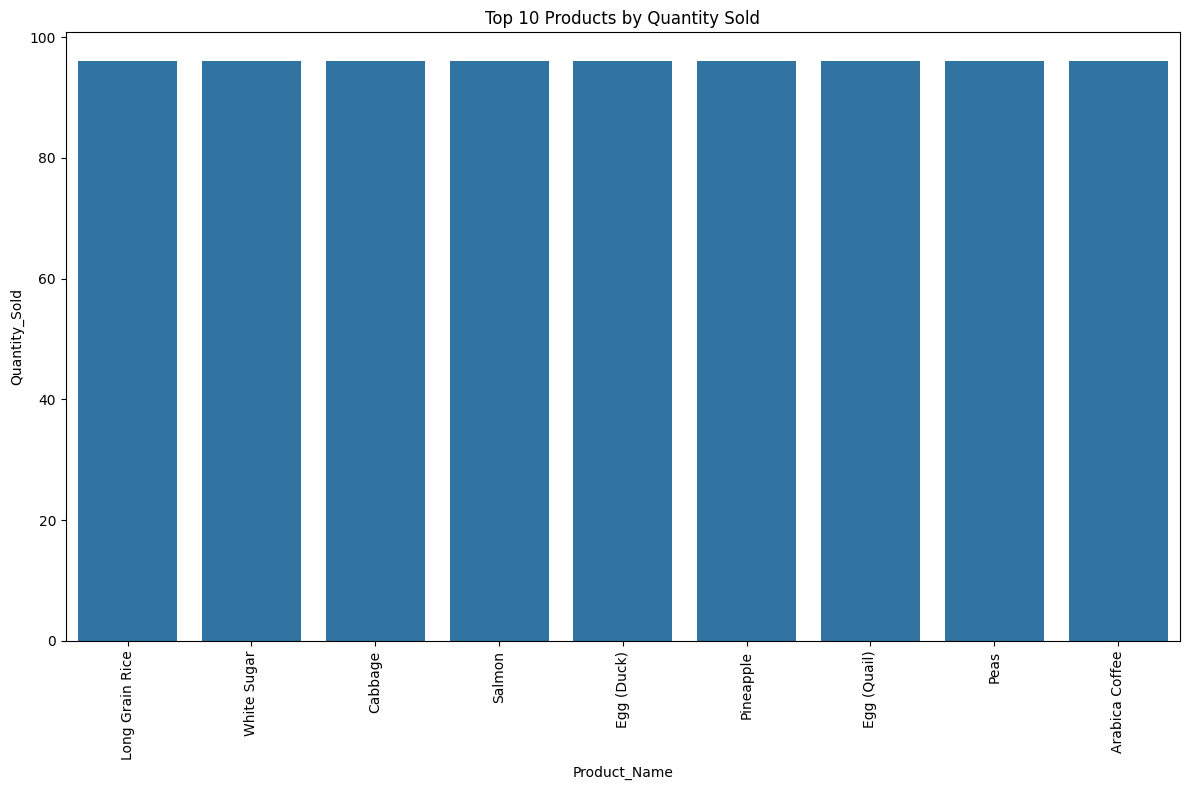

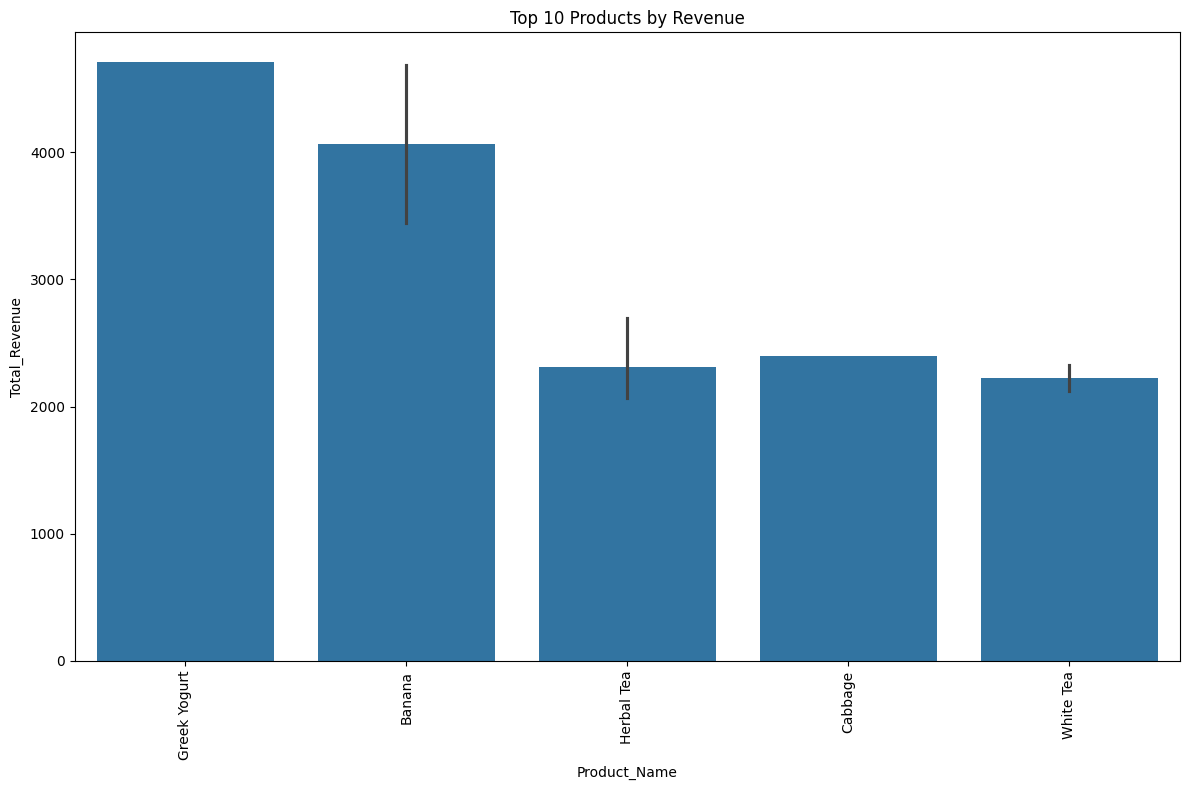

In [21]:
# Analyze top products
top_quantity, top_revenue = analyze_top_products(df_processed)

# Display top products by quantity
print("Top products by quantity sold:")
top_quantity[['Product_Name', 'Product_Category', 'Quantity_Sold', 'Unit_Price', 'Total_Revenue']].head(10)

In [22]:
# Display top products by revenue
print("Top products by revenue:")
top_revenue[['Product_Name', 'Product_Category', 'Quantity_Sold', 'Unit_Price', 'Total_Revenue']].head(10)

Top products by revenue:


,Product_Name,Product_Category,Quantity_Sold,Unit_Price,Total_Revenue
208,Greek Yogurt,Fruits & Vegetables,92.0,51.17,4707.64
325,Banana,Fruits & Vegetables,87.0,53.82,4682.34
113,Banana,Fruits & Vegetables,35.0,98.43,3445.05
630,Herbal Tea,Beverages,90.0,30.00,2700.00
685,Cabbage,Fruits & Vegetables,36.0,66.55,2395.80
66,White Tea,Beverages,93.0,25.00,2325.00
485,White Tea,Beverages,89.0,25.00,2225.00
161,Herbal Tea,Beverages,70.0,31.00,2170.00
349,White Tea,Beverages,85.0,25.00,2125.00
235,Herbal Tea,Beverages,69.0,30.00,2070.00


## 6. Analysis: Category Revenue

[PRIORITY] Analyzing category-wise revenue...


,Product_Category,Total_Revenue,Quantity_Sold,Product_Count
3,Fruits & Vegetables,91814.89,19374.0,332
1,Beverages,71429.55,4528.0,75
6,Seafood,61412.10,5563.0,90
2,Dairy,48244.15,10752.0,180
4,Grains & Pulses,33757.15,8871.0,162
5,Oils & Fats,18756.90,4587.0,77
0,Bakery,18309.80,4552.0,74


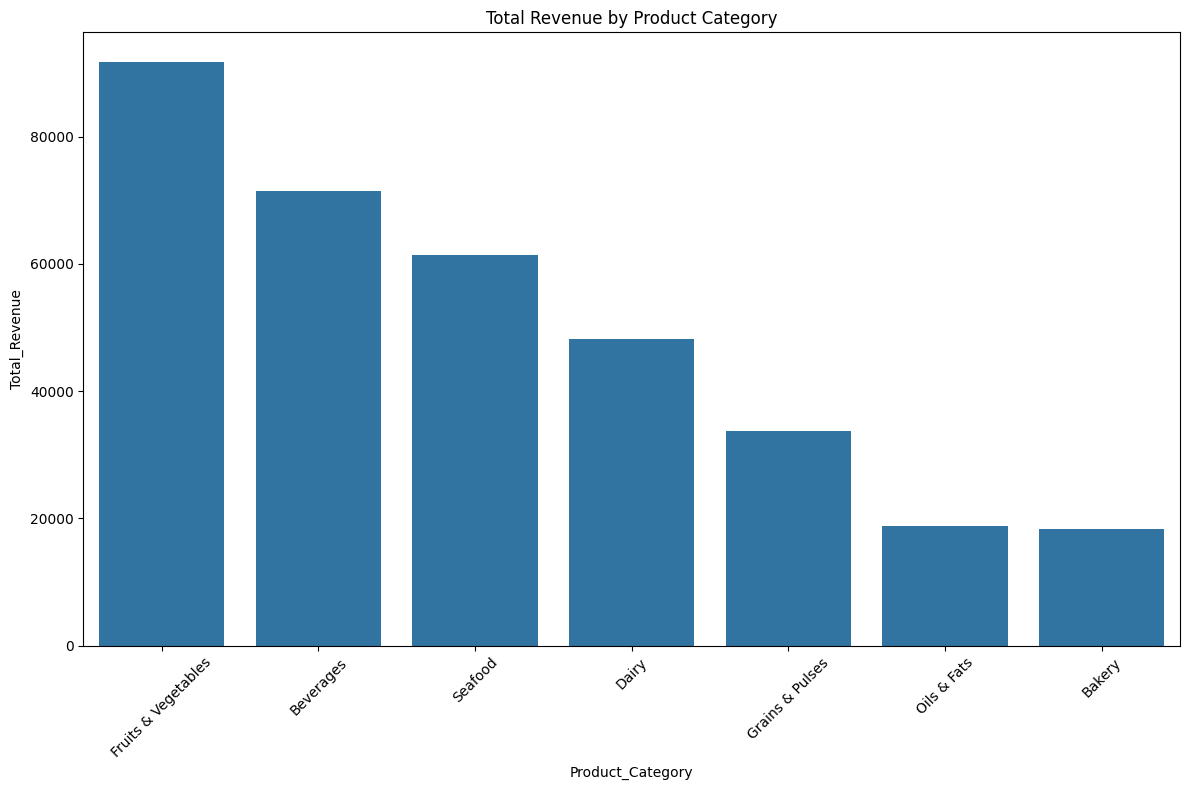

In [23]:
# Analyze category revenue
category_revenue = analyze_category_revenue(df_processed)

# Display category revenue
category_revenue

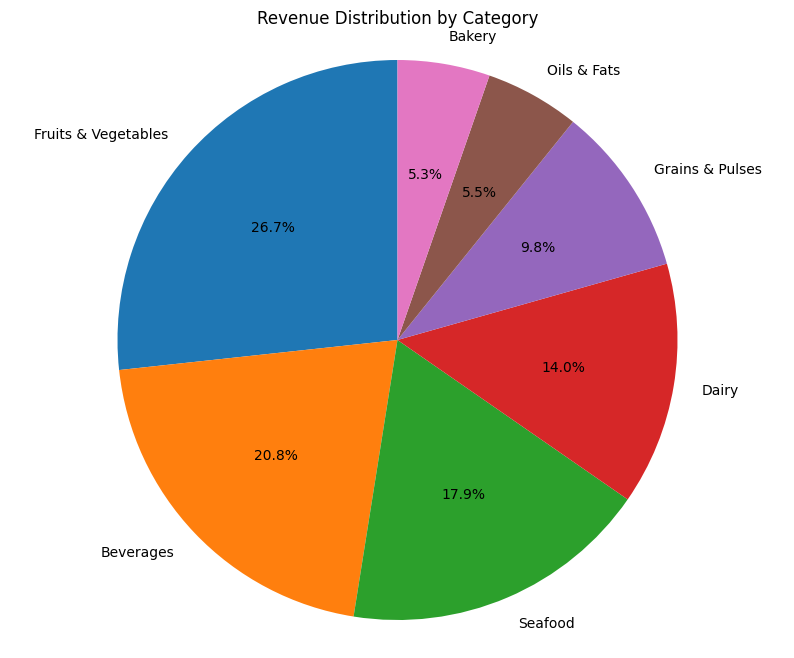

In [24]:
# Pie chart of revenue by category
plt.figure(figsize=(10, 8))
plt.pie(category_revenue['Total_Revenue'], labels=category_revenue['Product_Category'], 
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Revenue Distribution by Category')
plt.show()

## 7. Analysis: Expiry Risk

[PRIORITY] Analyzing expiry risk...
Found 990 products at risk of expiry


C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_3920\442546703.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=risk_counts, x='Risk_Category', y='Count', palette=colors)


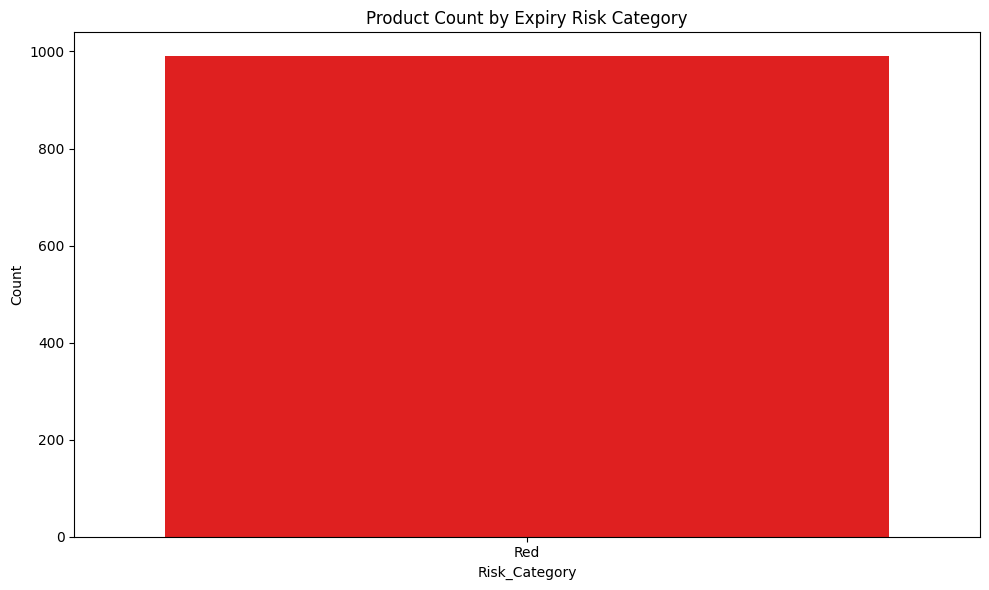

In [25]:
# Analyze expiry risk
expiry_risk = analyze_expiry_risk(df_processed)

if expiry_risk is not None:
    # Display products at risk of expiry
    print(f"Found {len(expiry_risk)} products at risk of expiry")
    expiry_risk[['Product_Name', 'Product_Category', 'Stock_On_Hand', 'Days_To_Expiry', 'Expiry_Risk', 'Unit_Price']].head(10)
else:
    print("No expiry data available")

In [26]:
# Calculate the value of inventory at risk of expiry
if expiry_risk is not None:
    red_risk = expiry_risk[expiry_risk['Expiry_Risk'] == 'Red']
    yellow_risk = expiry_risk[expiry_risk['Expiry_Risk'] == 'Yellow']
    
    red_value = (red_risk['Stock_On_Hand'] * red_risk['Unit_Price']).sum()
    yellow_value = (yellow_risk['Stock_On_Hand'] * yellow_risk['Unit_Price']).sum()
    
    print(f"Value of inventory at high risk (Red): ${red_value:.2f}")
    print(f"Value of inventory at medium risk (Yellow): ${yellow_value:.2f}")

Value of inventory at high risk (Red): $332069.70
Value of inventory at medium risk (Yellow): $0.00


## 8. Analysis: Discount Impact

In [27]:
# Analyze discount impact
discount_impact = analyze_discount_impact(df_processed)

if discount_impact is not None:
    print(f"Correlation between discount and quantity sold: {discount_impact:.4f}")

[OPTIONAL] Analyzing discount impact...
Discount data not available or all values are 0. Skipping discount impact analysis.


## 9. Executive Summary

In [28]:
# Generate executive summary
insights = generate_executive_summary(df_processed, overstocked, top_revenue, category_revenue, expiry_risk)

# Display summary
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

Generating executive summary...
1. [PRIORITY] There are 258 overstocked products with a total value of $117920.54. Consider running promotions or reducing reorder quantities.
2. [PRIORITY] The Fruits & Vegetables category generates $91814.89 in revenue (26.7% of total). Consider expanding this product line.
3. [PRIORITY] 990 products worth $332069.70 will expire within 30 days. Immediate action required with promotions or discounts.
4. [PRIORITY] 452 products have low turnover rates (<1), tying up $205607.76 in inventory. Review pricing strategy and promotions.
5. [PRIORITY] 457 products are below reorder levels, putting $10013.84 in revenue at risk. Expedite restocking of top sellers.


## 10. Inventory Optimization Recommendations

In [30]:
# Calculate inventory efficiency metrics
inventory_value = (df_processed['Stock_On_Hand'] * df_processed['Unit_Price']).sum()
total_revenue = df_processed['Total_Revenue'].sum()
avg_inventory_turnover = df_processed['Inventory_Turnover_Ratio'].mean()

print(f"Total Inventory Value: ${inventory_value:.2f}")
print(f"Total Revenue: ${total_revenue:.2f}")
print(f"Average Inventory Turnover Ratio: {avg_inventory_turnover:.2f}")

# Calculate percentage of overstocked value
overstock_percentage = (overstock_value / inventory_value) * 100
print(f"Percentage of inventory value that is overstocked: {overstock_percentage:.2f}%")

Total Inventory Value: $332069.70
Total Revenue: $343724.54
Average Inventory Turnover Ratio: 1.48
Percentage of inventory value that is overstocked: 35.51%


In [31]:
# Display recommendations
print("Inventory Optimization Recommendations:")
print("1. Implement promotions for the top overstocked items to reduce inventory levels")
print("2. Adjust reorder levels for slow-moving products")
print("3. Consider discounting products with approaching expiry dates")
print("4. Focus on high-revenue product categories for inventory expansion")
print("5. Implement just-in-time inventory for fast-moving items")

Inventory Optimization Recommendations:
1. Implement promotions for the top overstocked items to reduce inventory levels
2. Adjust reorder levels for slow-moving products
3. Consider discounting products with approaching expiry dates
4. Focus on high-revenue product categories for inventory expansion
5. Implement just-in-time inventory for fast-moving items
